# Importar Librerias

In [18]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Introducimos los datos: datatime

In [3]:
plt.style.use('ggplot')

start = dt.datetime(2013, 1, 1)
end = dt.datetime(2022, 10, 1)

tickers = ['AAPL', 'AMZN', 'MSFT', 'GOOGL','META']

stocks = web.DataReader(tickers,
                        'yahoo', start, end)['Adj Close']

stocks.head()

Symbols,AAPL,AMZN,MSFT,GOOGL,META
Date,,,,,
2013-01-02,16.890795,12.8655,22.838867,18.099348,28.000000
2013-01-03,16.677593,12.9240,22.532911,18.109859,27.770000
2013-01-04,16.213051,12.9575,22.111197,18.467718,28.760000
2013-01-07,16.117683,13.4230,22.069853,18.387136,29.420000
2013-01-08,16.161058,13.3190,21.954084,18.350851,29.059999


# Creamos variable en crear nuestro portafolio df["port"]

Symbols,AAPL,AMZN,MSFT,GOOGL,META,Port
Date,,,,,,
2022-09-30,8.181971,8.78318,10.197528,5.284721,4.845714,8.401731


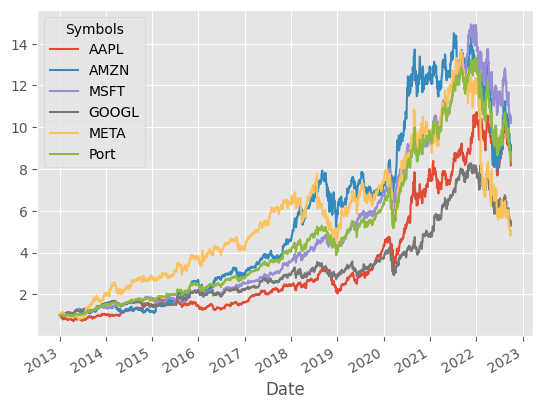

In [7]:
df = stocks.pct_change().dropna()
df['Port'] = df.mean(axis=1) # 20% apple, ... , 20% meta
(df+1).cumprod().plot()

(df+1).cumprod()[-1:]

# Ratio Sharpe
El índice de Sharpe es el índice más común para comparar la recompensa (retorno de la inversión) con el riesgo (desviación estándar). Esto nos permite ajustar los rendimientos de una inversión por la cantidad de riesgo que se tomó para lograrlo.
Mientras mas alto sea el valor, mas rentable será / riesgo.

<AxesSubplot: xlabel='Symbols'>

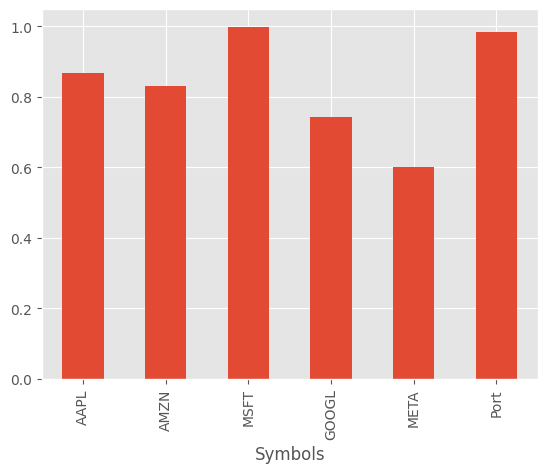

In [5]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate
sharpes = df.apply(sharpe_ratio, args=(N,rf,),axis=0)

sharpes.plot.bar()

# Ratio Sortino
La relación de Sortino es muy similar a la relación de Sharpe, con la única diferencia de que, mientras que la relación de Sharpe usa todas las observaciones para calcular la desviación estándar, la relación de Sortino solo considera la varianza perjudicial. Entonces, en el gráfico a continuación, solo estamos considerando las desviaciones coloreadas en rojo. La razón de esto es que no nos preocupan demasiado las desviaciones positivas, sin embargo, las desviaciones negativas son motivo de gran preocupación, ya que representan una pérdida de nuestro dinero

Text(0, 0.5, 'Sortino Ratio')

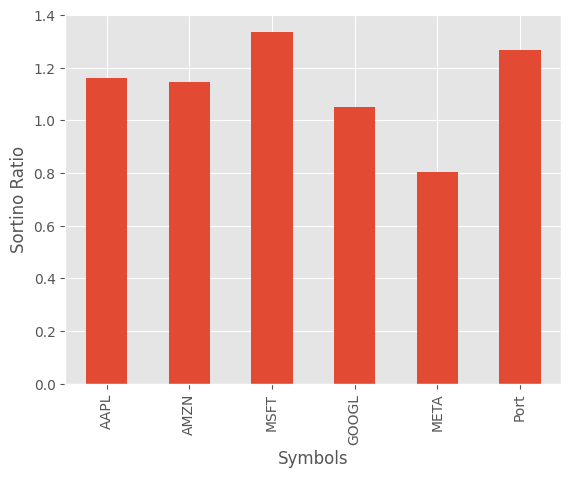

In [8]:
def sortino_ratio(series, N,rf):
    mean = series.mean() * N -rf
    std_neg = series[series<0].std()*np.sqrt(N)
    return mean/std_neg


sortinos = df.apply(sortino_ratio, args=(N,rf,), axis=0 )
sortinos.plot.bar()
plt.ylabel('Sortino Ratio')

# Max Drawdown
El drawdown cuantifica la caída más pronunciada desde el pico hasta el valle observada para una inversión. Esto es útil por varias razones, principalmente por el hecho de que no depende de que los rendimientos subyacentes se distribuyan normalmente. También nos da una indicación de la condicionalidad entre los incrementos de rendimiento. Mientras que en las proporciones anteriores, solo consideramos la recompensa general en relación con el riesgo, sin embargo, puede ser que los rendimientos consecutivos no sean independientes, lo que lleva a pérdidas inaceptablemente altas en un período de tiempo determinado

AttributeError: module 'matplotlib.pyplot' has no attribute 'yabel'

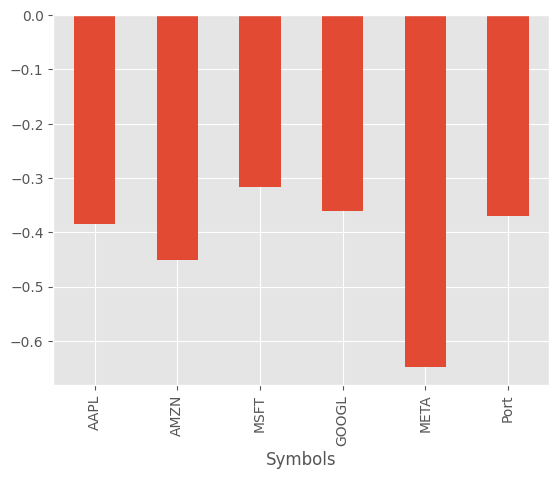

In [11]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()


max_drawdowns = df.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.yabel('Max Drawdown')

# Ratio Calmar
La relación riesgo/recompensa final que consideraremos es la relación Calmar. Esto es similar a las otras proporciones, con la diferencia clave de que la proporción de Calmar utiliza la reducción máxima en el denominador en lugar de la desviación estándar.

Text(0, 0.5, 'Calmar ratio')

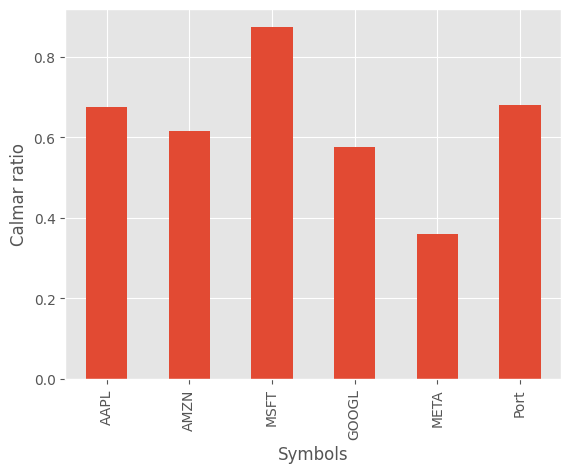

In [12]:
calmars = df.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')

# Creamos DataFrame

In [13]:
btstats = pd.DataFrame()
btstats['sortino'] = sortinos
btstats['sharpe'] = sharpes
btstats['maxdd'] = max_drawdowns
btstats['calmar'] = calmars

btstats

,sortino,sharpe,maxdd,calmar
Symbols,,,,
AAPL,1.161184,0.866530,-0.385159,0.675952
AMZN,1.147446,0.830370,-0.451628,0.614954
MSFT,1.336887,0.998778,-0.316774,0.875126
GOOGL,1.049160,0.742583,-0.361646,0.576838
META,0.803448,0.600980,-0.648333,0.359184
Port,1.265980,0.985051,-0.369946,0.679439


# Ordenamos los datos

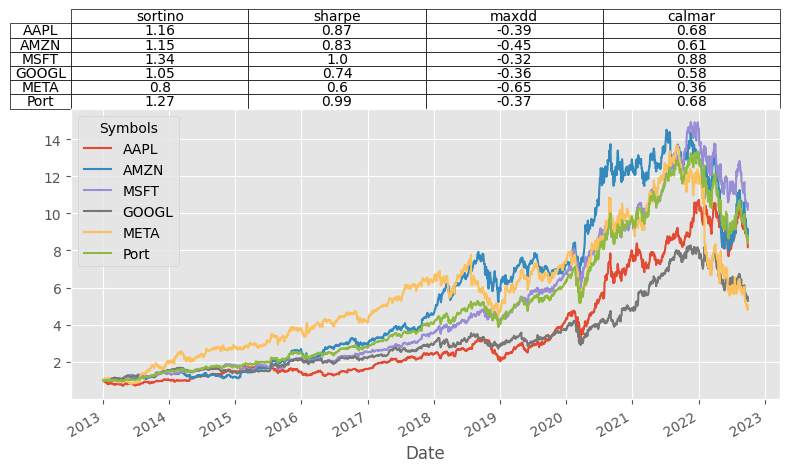

In [14]:
(df+1).cumprod().plot(figsize=(8,5))
plt.table(cellText=np.round(btstats.values,2), colLabels=btstats.columns,
          rowLabels=btstats.index,rowLoc='center',cellLoc='center',loc='top',
          colWidths=[0.25]*len(btstats.columns))
plt.tight_layout()

# Creamos los datos de Correlación
Si existe menos correlación entre los distintos activos, existe menos riego en cartera


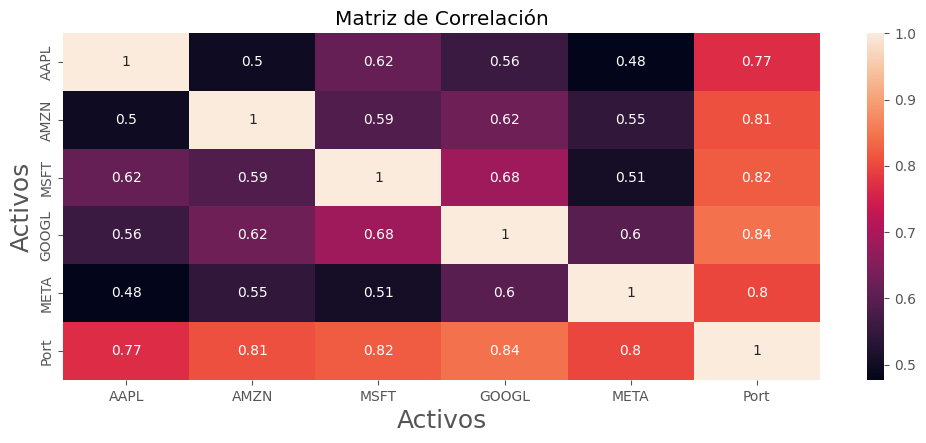

In [19]:
correlation_mat = df.corr()
plt.figure(figsize=(12.2,4.5))
sns.heatmap(correlation_mat, annot = True)
plt.title('Matriz de Correlación')
plt.xlabel('Activos',fontsize=18)
plt.ylabel('Activos',fontsize=18)
plt.show()